# Imports

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import keras_nlp

2025-03-17 19:31:10.832505: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-17 19:31:10.958592: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-17 19:31:11.004238: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742250671.105962    5566 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742250671.115946    5566 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-17 19:31:11.237120: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

# Import the dataset

In [5]:
imdb = tfds.load("imdb_reviews", as_supervised=True)

2025-03-17 19:31:16.221647: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [6]:
imdb

{'train': <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 'test': <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 'unsupervised': <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>}

In [7]:
example = next(iter(imdb['train'].take(1)))
example

2025-03-17 19:31:16.405901: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-03-17 19:31:16.425072: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(<tf.Tensor: shape=(), dtype=string, numpy=b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.">,
 <tf.Tensor: shape=(), dtype=int64, numpy=0>)

In [8]:
review, label = example

In [9]:
review.numpy()

b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."

In [10]:
label.numpy()

0

In [11]:
train_reviews = imdb['train'].map(lambda review, label: review)
train_labels = imdb['train'].map(lambda review, label: label)

test_reviews = imdb['test'].map(lambda review, label: review)
test_labels = imdb['test'].map(lambda review, label: label)

In [12]:
list(train_reviews.take(2))

2025-03-17 19:31:16.569111: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-03-17 19:31:16.569783: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[<tf.Tensor: shape=(), dtype=string, numpy=b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.">,
 <tf.Tensor: shape=(), dtype=string, numpy=b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. Howev

# Subword tokenization

In [13]:
VOCAB_SIZE = 10000
MAX_LENGTH = 120
PADDING_TYPE = 'pre'
TRUNC_TYPE= 'post'

In [14]:
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)

vectorize_layer.adapt(train_reviews)

2025-03-17 19:32:37.189962: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [15]:
def padding_func(sequences):
  sequences = sequences.ragged_batch(batch_size=sequences.cardinality())

  sequences = sequences.get_single_element()

  padded_sequences = tf.keras.utils.pad_sequences(sequences.numpy(),
                                                  maxlen=MAX_LENGTH,
                                                  truncating=TRUNC_TYPE,
                                                  padding=PADDING_TYPE)

  padded_sequences = tf.data.Dataset.from_tensor_slices(padded_sequences)

  return padded_sequences

In [16]:
train_sequences = train_reviews.map(lambda text: vectorize_layer(text)).apply(padding_func)

2025-03-17 19:32:40.445219: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 46573608 exceeds 10% of free system memory.


In [17]:
imdb_vocab_fullword = vectorize_layer.get_vocabulary()
imdb_vocab_fullword

['',
 '[UNK]',
 'the',
 'and',
 'a',
 'of',
 'to',
 'is',
 'in',
 'it',
 'i',
 'this',
 'that',
 'br',
 'was',
 'as',
 'for',
 'with',
 'movie',
 'but',
 'film',
 'on',
 'not',
 'you',
 'are',
 'his',
 'have',
 'he',
 'be',
 'one',
 'its',
 'at',
 'all',
 'by',
 'an',
 'they',
 'from',
 'who',
 'so',
 'like',
 'her',
 'just',
 'or',
 'about',
 'has',
 'if',
 'out',
 'some',
 'there',
 'what',
 'good',
 'when',
 'more',
 'very',
 'even',
 'she',
 'my',
 'no',
 'up',
 'would',
 'which',
 'only',
 'time',
 'really',
 'story',
 'their',
 'were',
 'had',
 'see',
 'can',
 'me',
 'than',
 'we',
 'much',
 'well',
 'been',
 'get',
 'will',
 'into',
 'also',
 'because',
 'other',
 'do',
 'people',
 'bad',
 'great',
 'first',
 'how',
 'most',
 'him',
 'dont',
 'made',
 'then',
 'movies',
 'make',
 'films',
 'could',
 'way',
 'them',
 'any',
 'too',
 'after',
 'characters',
 'think',
 'watch',
 'two',
 'many',
 'being',
 'seen',
 'character',
 'never',
 'little',
 'acting',
 'where',
 'plot',
 'be

In [18]:
sample_sequence = train_sequences.take(1).get_single_element()
sample_sequence

<tf.Tensor: shape=(120,), dtype=int32, numpy=
array([   0,    0,    0,    0,   11,   14,   34,  412,  384,   18,   90,
         28,    1,    8,   33, 1322, 3560,   42,  487,    1,  191,   24,
         85,  152,   19,   11,  217,  316,   28,   65,  240,  214,    8,
        489,   54,   65,   85,  112,   96,   22, 5596,   11,   93,  642,
        743,   11,   18,    7,   34,  394, 9522,  170, 2464,  408,    2,
         88, 1216,  137,   66,  144,   51,    2,    1, 7558,   66,  245,
         65, 2870,   16,    1, 2860,    1,    1, 1426, 5050,    3,   40,
          1, 1579,   17, 3560,   14,  158,   19,    4, 1216,  891, 8040,
          8,    4,   18,   12,   14, 4059,    5,   99,  146, 1241,   10,
        237,  704,   12,   48,   24,   93,   39,   11, 7339,  152,   39,
       1322,    1,   50,  398,   10,   96, 1155,  851,  141,    9],
      dtype=int32)>

In [19]:
decoded_text = [imdb_vocab_fullword[token] for token in sample_sequence]
decoded_text

['',
 '',
 '',
 '',
 'this',
 'was',
 'an',
 'absolutely',
 'terrible',
 'movie',
 'dont',
 'be',
 '[UNK]',
 'in',
 'by',
 'christopher',
 'walken',
 'or',
 'michael',
 '[UNK]',
 'both',
 'are',
 'great',
 'actors',
 'but',
 'this',
 'must',
 'simply',
 'be',
 'their',
 'worst',
 'role',
 'in',
 'history',
 'even',
 'their',
 'great',
 'acting',
 'could',
 'not',
 'redeem',
 'this',
 'movies',
 'ridiculous',
 'storyline',
 'this',
 'movie',
 'is',
 'an',
 'early',
 'nineties',
 'us',
 'propaganda',
 'piece',
 'the',
 'most',
 'pathetic',
 'scenes',
 'were',
 'those',
 'when',
 'the',
 '[UNK]',
 'rebels',
 'were',
 'making',
 'their',
 'cases',
 'for',
 '[UNK]',
 'maria',
 '[UNK]',
 '[UNK]',
 'appeared',
 'phony',
 'and',
 'her',
 '[UNK]',
 'affair',
 'with',
 'walken',
 'was',
 'nothing',
 'but',
 'a',
 'pathetic',
 'emotional',
 'plug',
 'in',
 'a',
 'movie',
 'that',
 'was',
 'devoid',
 'of',
 'any',
 'real',
 'meaning',
 'i',
 'am',
 'disappointed',
 'that',
 'there',
 'are',
 'movi

In [20]:
decoded_text = ' '.join(decoded_text)
decoded_text

'    this was an absolutely terrible movie dont be [UNK] in by christopher walken or michael [UNK] both are great actors but this must simply be their worst role in history even their great acting could not redeem this movies ridiculous storyline this movie is an early nineties us propaganda piece the most pathetic scenes were those when the [UNK] rebels were making their cases for [UNK] maria [UNK] [UNK] appeared phony and her [UNK] affair with walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning i am disappointed that there are movies like this ruining actors like christopher [UNK] good name i could barely sit through it'

In [21]:
#Compute the subword vocabulary and save to a file
keras_nlp.tokenizers.compute_word_piece_vocabulary(
    train_reviews,
    vocabulary_size=8000,
    reserved_tokens=["[PAD]", "[UNK]"],
    vocabulary_output_file='imdb_vocab_subwords.txt'
)

In [22]:
# Initialize the subword tokenizer
subword_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary='./imdb_vocab_subwords.txt'
)

2025-03-17 19:35:25.042960: W tensorflow_text/core/kernels/fast_wordpiece_tokenizer_model_builder.cc:324] The empty string is found in the vocabulary, which takes place in the token id space but will never be used in the result. Consider cleaning it from the vocabulary.
2025-03-17 19:35:25.043542: W tensorflow_text/core/kernels/fast_wordpiece_tokenizer_model_builder.cc:336] The empty suffix token is found in the vocabulary, which takes place in token id space but will (almost) never be used in the result. Consider cleaning it from the vocabulary.


In [23]:
subword_tokenizer.get_vocabulary()

['[PAD]',
 '[UNK]',
 '!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '{',
 '|',
 '}',
 '~',
 '',
 '¡',
 '¢',
 '£',
 '¤',
 '¦',
 '§',
 '¨',
 '«',
 '®',
 '°',
 '³',
 '´',
 '·',
 'º',
 '»',
 '½',
 '¾',
 '¿',
 'À',
 'Á',
 'Ã',
 'Ä',
 'Å',
 'È',
 'É',
 'Ê',
 'Õ',
 'Ø',
 'Ü',
 'ß',
 'à',
 'á',
 'â',
 'ã',
 'ä',
 'å',
 'æ',
 'ç',
 'è',
 'é',
 'ê',
 'ë',
 'ì',
 'í',
 'î',
 'ï',
 'ð',
 'ñ',
 'ò',
 'ó',
 'ô',
 'ö',
 'ø',
 'ù',
 'ú',
 'û',
 'ü',
 'ý',
 'ō',
 '–',
 '‘',
 '’',
 '“',
 '”',
 '…',
 '₤',
 '\uf0b7',
 't

In [24]:
subword_tokenizer.vocabulary_size()

7635

In [25]:
sample_review = train_reviews.take(1).get_single_element()
sample_review

<tf.Tensor: shape=(), dtype=string, numpy=b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.">

In [26]:
tokenized_string = subword_tokenizer.tokenize(sample_review)
tokenized_string

<tf.Tensor: shape=(156,), dtype=int32, numpy=
array([ 209,  175,  195,  674,  630,  178,   15,  680,    8,   85,  189,
         77, 2000,  170,  192, 1766, 4426,  203,  700,   42, 1864, 2116,
         15, 1961,  185,  255,  328,   13,  182,  173,  392,  535,  189,
        231,  442,  390,  170,  740,   15,  597,  231,  255,  282,  263,
        186, 1680, 6036,  173,  178,    8,   84,  908, 1045,   15,  209,
        178,  168,  195,  638, 4963, 1657, 1422, 3263,  637,   15,  176,
        258, 1648,  312,  234,  330,  223,  164,   36, 1532, 5576,  758,
        326, 4207,  174,  234,  415,  231, 3925,  180, 4554,  174,   15,
       3651,   36,  363, 6855, 1985, 2230, 1828,  303, 1931, 7070,   13,
        165,  202, 5417,   14,  298, 2118,  179, 4426,  175,  353,  182,
         66, 1648, 1210,   81, 7017,  170,   66,  178,  172,  175, 5789,
        166,  269,  324, 1606,   15,   42,  427,  938,  172,  219,  185,
        266,  199,  173,   13, 3231,  204,  471,    8,   84,  199, 1766,
     

In [27]:
original_string = subword_tokenizer.detokenize(tokenized_string)
original_string

"This was an absolutely terrible movie . Don ' t be lured in by Christopher Walken or Michael Ironside . Both are great actors , but this must simply be their worst role in history . Even their great acting could not redeem this movie ' s ridiculous storyline . This movie is an early nineties US propaganda piece . The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions . Maria Conchita Alonso appeared phony , and her pseudo - love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning . I am disappointed that there are movies like this , ruining actor ' s like Christopher Walken ' s good name . I could barely sit through it ."

In [28]:
# Define sample sentence
sample_string = 'TensorFlow, from basics to mastery'

# Encode using the plain text tokenizer
tokenized_string = vectorize_layer(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

# Decode and print the result
decoded_text = [imdb_vocab_fullword[token] for token in tokenized_string]
original_string = ' '.join(decoded_text)
print ('The original string: {}'.format(original_string))

Tokenized string is [ 1 36  1  6  1]
The original string: [UNK] from [UNK] to [UNK]


In [29]:
# Encode using the subword text encoder
tokenized_string = subword_tokenizer.tokenize(sample_string)
print('Tokenized string is {}'.format(tokenized_string))

# Decode and print the results
original_string = subword_tokenizer.detokenize(tokenized_string)
print('The original string: {}'.format(original_string))


Tokenized string is [  53 2235  543 1827 3024   13  198 1659  174  167 2220  238]
The original string: TensorFlow , from basics to mastery


In [30]:
# Show token to subword mapping:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, subword_tokenizer.detokenize([ts])))

53 ----> T
2235 ----> ##ens
543 ----> ##or
1827 ----> ##F
3024 ----> ##low
13 ----> ,
198 ----> from
1659 ----> basic
174 ----> ##s
167 ----> to
2220 ----> master
238 ----> ##y


#Training the model

In [31]:
SHUFFLE_BUFFER_SIZE = 10000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 32

# Generate integer sequences using the subword tokenizer
train_sequences_subword = train_reviews.map(lambda review: subword_tokenizer.tokenize(review)).apply(padding_func)
test_sequences_subword = test_reviews.map(lambda review: subword_tokenizer.tokenize(review)).apply(padding_func)

# Combine the integer sequence and labels
train_dataset_vectorized = tf.data.Dataset.zip(train_sequences_subword,train_labels)
test_dataset_vectorized = tf.data.Dataset.zip(test_sequences_subword,test_labels)

# Optimize the datasets for training
train_dataset_final = (train_dataset_vectorized
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .cache()
                       .prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
                       .batch(BATCH_SIZE)
                       )

test_dataset_final = (test_dataset_vectorized
                      .cache()
                      .prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
                      .batch(BATCH_SIZE)
                      )

2025-03-17 19:35:33.804364: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 34388428 exceeds 10% of free system memory.
2025-03-17 19:35:41.120265: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33778776 exceeds 10% of free system memory.


In [32]:
# Define dimensionality of the embedding
EMBEDDING_DIM = 64

# Build the model
model = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_LENGTH,)),
    tf.keras.layers.Embedding(subword_tokenizer.vocabulary_size(), EMBEDDING_DIM),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 120, 64)        │       488,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 489,037 (1.87 MB)

 Trainable params: 489,037 (1.87 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
num_epochs = 10

# Set the training parameters
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Start training
history = model.fit(train_dataset_final, epochs=num_epochs, validation_data=test_dataset_final)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.6299 - loss: 0.6229 - val_accuracy: 0.7967 - val_loss: 0.4364
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8352 - loss: 0.3781 - val_accuracy: 0.8054 - val_loss: 0.4223
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8671 - loss: 0.3200 - val_accuracy: 0.8012 - val_loss: 0.4395
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8819 - loss: 0.2907 - val_accuracy: 0.7959 - val_loss: 0.4633
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8923 - loss: 0.2713 - val_accuracy: 0.7925 - val_loss: 0.4888
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8988 - loss: 0.2571 - val_accuracy: 0.7884 - val_loss: 0.5150
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9039 - loss: 0.2461 - val_accuracy: 0.7841 - val_loss: 0.5403
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9086 - loss: 0.2369 - val_accuracy: 0.

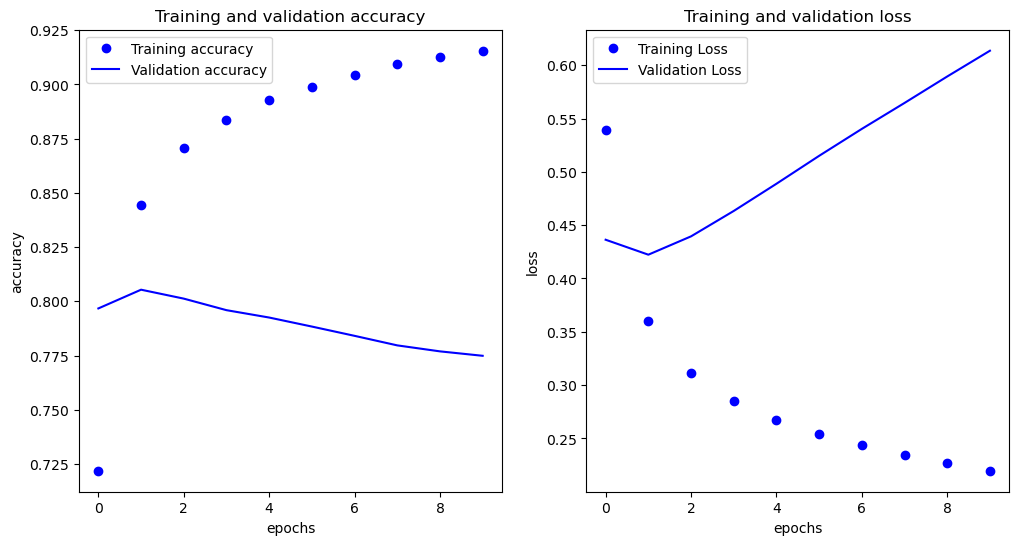

In [34]:
def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  fig, ax = plt.subplots(1,2, figsize=(12, 6))
  ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
  ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
  ax[0].set_title('Training and validation accuracy')
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('accuracy')
  ax[0].legend()

  ax[1].plot(epochs, loss, 'bo', label='Training Loss')
  ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
  ax[1].set_title('Training and validation loss')
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('loss')
  ax[1].legend()

  plt.show()

plot_loss_acc(history)

In [35]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import keras_nlp